In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/MCI-CN/MCI-CN/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 858 images belonging to 2 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/MCI-CN/MCI-CN/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 214 images belonging to 2 classes.


In [11]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/MCI-CN/MCI-CN/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 286 images belonging to 2 classes.


In [12]:
base_model = ResNet50(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

In [13]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [14]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dense(1,activation='sigmoid'))

In [15]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [16]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [18]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) 

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [19]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=METRICS)


In [20]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
27/27 [==============================] - 200s 7s/step - loss: 0.6909 - accuracy: 0.6154 - precision: 0.6477 - recall: 0.6881 - auc: 0.6409 - f1_score: 0.6640 - val_loss: 1.4496 - val_accuracy: 0.5654 - val_precision: 0.5634 - val_recall: 1.0000 - val_auc: 0.7366 - val_f1_score: 0.7238 - lr: 0.0100
Epoch 2/20
27/27 [==============================] - 15s 569ms/step - loss: 0.5130 - accuracy: 0.7494 - precision: 0.7866 - recall: 0.7588 - auc: 0.8301 - f1_score: 0.7700 - val_loss: 1.0152 - val_accuracy: 0.6449 - val_precision: 0.6325 - val_recall: 0.8750 - val_auc: 0.8089 - val_f1_score: 0.7307 - lr: 0.0063
Epoch 3/20
27/27 [==============================] - 15s 558ms/step - loss: 0.5016 - accuracy: 0.7821 - precision: 0.8088 - recall: 0.8004 - auc: 0.8370 - f1_score: 0.8047 - val_loss: 0.6439 - val_accuracy: 0.6916 - val_precision: 0.6709 - val_recall: 0.8833 - val_auc: 0.8376 - val_f1_score: 0.7563 - lr: 0.0040
Epoch 4/20
27/27 [==============================] - 15s 560ms/step

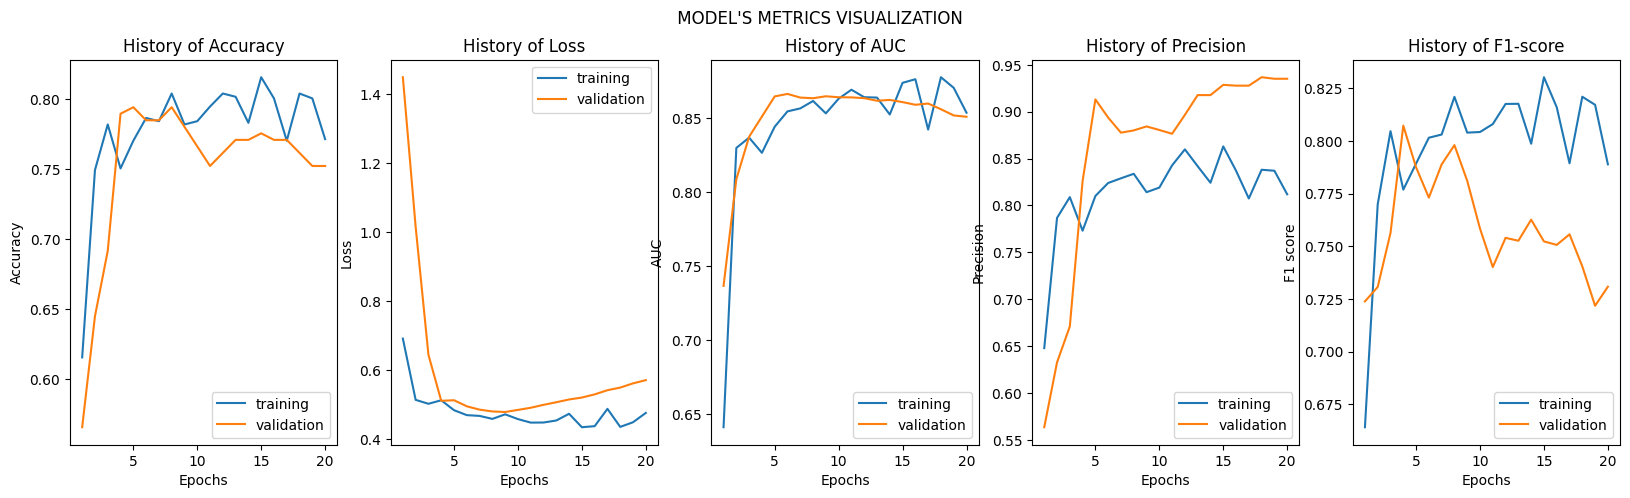

In [21]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [22]:
scores = model.evaluate(test_dataset)


9/9 [==============================] - 87s 11s/step - loss: 0.2693 - accuracy: 0.9021 - precision: 0.9703 - recall: 0.7967 - auc: 0.9576 - f1_score: 0.8793


In [23]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.9020978808403015
Precision =  0.9702970385551453
Recall =  0.7967479825019836
AUC =  0.9576038718223572
F1_score =  0.8793023824691772
